In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from random import sample
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

def scale_data(frame):
    cols = frame.columns
    frame = pd.DataFrame(sc.fit_transform(frame))
    frame.columns = cols
    
    return frame

def split_train_and_test(full_dataset, percent_split):
    if not(percent_split > 0 and percent_split < 1):
        print("Invalid Split: Value must be between 0 and 1")
        return None

    data_points = full_dataset.shape[0]

    #Create Training_list
    training_list = sample(range(data_points), int(percent_split*data_points))
    training_list.sort()

    #Create Test List
    full = [x for x in range(0,data_points)]
    full_set = set(full)
    test_list = list(full_set - set(training_list))
    test_list.sort()

    training_set = full_dataset.iloc[training_list]
    test_set = full_dataset.iloc[test_list]

    training_set.reset_index(inplace=True, drop=True)
    test_set.reset_index(inplace=True, drop=True)

    if (training_set.shape[0] + test_set.shape[0]) == data_points:
        print("Good Split")
        return {'training_set':training_set, 'test_set': test_set}
    else:
        print("Whoops! BAD SPLIT. Not sure what happened :/")
        return None

def show_results(trained_model, X, Y):
    try:
        truth = Y.to_numpy()
    except:
        truth = Y
    
    prediction = trained_model.predict(X)
    prediction = np.around(prediction)
    
    #Scale to within range
    predict_series = pd.Series(prediction)
    upper = np.amax(truth)
    lower = np.amin(truth)
    predict_series[predict_series < lower] = lower
    predict_series[predict_series > upper] = upper
    
    prediction = predict_series.to_numpy()

    print("Max, Min: ", np.amax(prediction), np.amin(prediction))
    diff = truth - prediction
    
    rand_prediction = np.random.randint(np.amin(truth), np.amax(truth)+1, len(truth))
    rand_diff = truth - rand_prediction
    
    ave_SSE = np.sqrt(np.dot(diff, diff))/len(Y)
    print("\nAverage Error (Actual): %.4f"%(ave_SSE))
    ave_rand_SSE = np.sqrt(np.dot(rand_diff, rand_diff))/len(Y)
    print("Average Error (Random): %.4f"%(ave_rand_SSE))
    
    diff_series = pd.Series(diff).value_counts()
    diff_cnts = diff_series.to_numpy()
    total = np.sum(diff_cnts)
    diff_labels = diff_series.index.values
    
    num_classes = len(Y.value_counts().to_numpy())
    print_class_breakdown(truth, "Actual", 5, True)
    print_class_breakdown(prediction, "Prediction", 5, False)
    print_class_breakdown(rand_prediction, "Random", 5, False)
    
    
    
    print("\nError Breakdown:")
    max_label = 5
    for i in range(-len(Y.value_counts()), (len(Y.value_counts())+1)):
        label = " "*max_label+str(i)
        label = label[len(label)-max_label:len(label)]
        print(label, end='|  ')
        if i in diff_labels:
            perc = diff_cnts[diff_labels.tolist().index(i)]*100/total
        else:
            perc = 0
        
        print("%.2f%%"%(perc))
    
    #plt.hist([diff, rand_diff], 8, density=True, histtype='bar', color=['green', 'red'], label=['Actual', 'Random Guessing'])
    plt.hist([diff, rand_diff], 8, density=True, color=['green', 'red'], label=['Actual', 'Random Guessing'])
    plt.title("Difference Histogram")
    plt.legend(prop={'size': 10})
    plt.show()
    
def print_class_breakdown(dataset, desc, num_classes, class_label):
    try:
        breakdown = dataset['Success'].value_counts()
    except:
        dataset = pd.Series(dataset)
        breakdown = dataset.value_counts()
    
    classes = breakdown.index.values
    
    breakdown = breakdown.to_numpy()
    total = np.sum(breakdown)

    max_desc = 14
    if (class_label):
        print(" "*(max_desc+5), end="")
        for i, br in enumerate(breakdown):
            print(i, end=" "*9)
        print("")
            
    desc = desc + " "*max_desc
    desc = desc[0:max_desc]
    print(desc, end="| ")
    for cnt in range(0,num_classes):
        if cnt in classes:
            perc = breakdown[classes.tolist().index(cnt)]*100/total
        else:
            perc = 0
        num_string = " "*8+" %.3f%%"%(perc)
        num_string = num_string[len(num_string)-8:len(num_string)]
        print(num_string, end="  ")
    print("")

def print_set_info(full_set, Y, Y_test):
    print("\nTrain Set Size: %.2f%% --> %d"%(Y.shape[0]*100/(Y.shape[0]+Y_test.shape[0]), Y.shape[0]))
    print("Test Set Size:  %.2f%% --> %d\n"%(Y_test.shape[0]*100/(Y.shape[0]+Y_test.shape[0]), Y_test.shape[0]))

    print("Success Classification:")
    num_classes = len(full_set['Success'].value_counts().to_numpy())
    
    print_class_breakdown(full_set, "Full Dataset", num_classes, True)
    print_class_breakdown(Y, "Training Set", num_classes, False)
    print_class_breakdown(Y_test, "Test Set", num_classes, False)

def add_year(dataset):
    year_list = []
    for date in dataset['Date']:
        year = date.split('-')[0]
        if year is not(None):
            if int(year) > 1800:
                year_list.append(int(year))
            else:
                year_list.append(int(0))
    
    dataset['Year'] = year_list
    dataset = dataset[dataset['Year'] > 1800]
    dataset.reset_index(inplace=True, drop=True)
    
    return dataset

def enumerate_popularity(range_list, dataset):
    en_frame = pd.DataFrame(columns=list(dataset))
    for i,rng in enumerate(range_list):
        sub_frame = dataset[(dataset['Popularity'] >= rng[0]) & (dataset['Popularity'] < rng[1])]
        sub_frame['Success'] = [i]*sub_frame.shape[0]
        en_frame = pd.concat([en_frame, sub_frame], axis=0, ignore_index=True)
        print("Subset [%d, %d], Class %d --> %.3f%%"%(rng[0], rng[1], i, (sub_frame.shape[0]*100/dataset.shape[0])))
    
    return en_frame
   
data_file = "../data/full_dataset.csv"
big_frame = pd.read_csv(data_file, index_col=False)
big_frame = big_frame.astype({'Success': int})
print(big_frame.info())

big_frame = add_year(big_frame)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870664 entries, 0 to 1870663
Data columns (total 19 columns):
Artist(s)           object
Date                object
Duration            int64
Popularity          int64
Song Title          object
Success             int64
acousticness        float64
danceability        float64
energy              float64
id                  object
instrumentalness    float64
key                 int64
liveness            float64
loudness            float64
mode                int64
speechiness         float64
tempo               float64
time_signature      int64
valence             float64
dtypes: float64(9), int64(6), object(4)
memory usage: 271.2+ MB
None


In [36]:
features = [
    'Duration',
    'acousticness',
    'danceability',
    'energy', 
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence',
    'Year',
]

target = 'Success'

ranges = [
    (0,10),
    (10,30),
    (30,50),
    (50,100)
]

big_frame = enumerate_popularity(ranges, big_frame)
print(big_frame['Success'].value_counts())

get_less = split_train_and_test(big_frame, 0.3)
subset = get_less['training_set']

data_sets = split_train_and_test(subset, 0.7)
training_set = data_sets['training_set']
test_set = data_sets['test_set']

X = training_set[features]
X = scale_data(X)
Y = training_set[target]

X_test = test_set[features]
X_test = scale_data(X_test)
Y_test = test_set[target]

print_set_info(big_frame, Y, Y_test)

/home/ronnie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Subset [0, 10], Class 0 --> 61.916%
Subset [10, 30], Class 1 --> 25.021%
Subset [30, 50], Class 2 --> 10.360%
Subset [50, 100], Class 3 --> 2.703%
0    1158182
1     468040
2     193781
3      50552
Name: Success, dtype: int64
Good Split
Good Split

Train Set Size: 70.00% --> 392816
Test Set Size:  30.00% --> 168350

Success Classification:
                   0         1         2         3         
Full Dataset  |  61.916%   25.021%   10.360%    2.703%  
Training Set  |  61.982%   24.971%   10.322%    2.724%  
Test Set      |  61.795%   25.010%   10.460%    2.734%  


Max, Min:  2.0 0.0

Average Error (Actual): 0.0021
Average Error (Random): 0.0041
                   0         1         2         3         
Actual        |  61.795%   25.010%   10.460%    2.734%    0.000%  
Prediction    |  42.947%   57.030%    0.023%    0.000%    0.000%  
Random        |  25.129%   25.076%   24.676%   25.119%    0.000%  

Error Breakdown:
   -4|  0.00%
   -3|  0.00%
   -2|  0.01%
   -1|  31.41%
    0|  46.38%
    1|  16.40%
    2|  5.32%
    3|  0.48%
    4|  0.00%


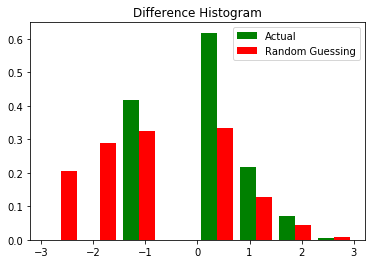

In [37]:
trained_ANN = MLPRegressor(
        hidden_layer_sizes = (1000,),
        solver='adam',
        activation='logistic',
        batch_size = int(0.01*X.shape[0]),
        learning_rate='adaptive',
        learning_rate_init=1,
        verbose=False,
        momentum=0.5,
        alpha = 0.001,
        max_iter = 10000,
        random_state=1
    )

trained_ANN.fit(X,Y)
show_results(trained_ANN, X_test, Y_test)